# Step 1 — Load & Inspect

In [1]:
!pip install -q kagglehub[pandas-datasets]

In [2]:
import kagglehub
import pandas as pd

# File path inside the dataset
file_path = "training.1600000.processed.noemoticon.csv"

# Load dataset (no header in file, so we add manually)
df = kagglehub.load_dataset(
    kagglehub.KaggleDatasetAdapter.PANDAS,
    "abhi8923shriv/sentiment-analysis-dataset",
    file_path,
    pandas_kwargs={"header": None, "encoding": "latin-1"}  # latin-1 avoids encoding errors
)

# Assign column names (6 columns as described)
df.columns = ["polarity","tweet_id","date","query","user","text"]

# Show basic info
print("Shape of dataset:", df.shape)
print("\nPolarity distribution:\n", df["polarity"].value_counts())
print("\nFirst 3 rows:\n", df.head(3))

/tmp/ipython-input-3112979762.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Shape of dataset: (1048573, 6)

Polarity distribution:
 polarity
0                     668925
4                     248576
0                     131071
polarity of tweet          1
Name: count, dtype: int64

First 3 rows:
              polarity         tweet_id                          date  \
0  polarity of tweet   id of the tweet             date of the tweet   
1                   0       1467810672  Mon Apr 06 22:19:49 PDT 2009   
2                   0       1467810917  Mon Apr 06 22:19:53 PDT 2009   

      query           user                                               text  
0     query           user                                 text of the tweet   
1  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...  
2  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...  


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


# Step 2 — Cleaning

In [3]:
# Drop the first row (which contains column description, not data)
df = df.drop(index=0).reset_index(drop=True)

# Convert polarity column to integer
df["polarity"] = df["polarity"].astype(int)

# Keep only polarity + text columns
df = df[["polarity", "text"]]

# Drop missing or empty texts
df = df.dropna(subset=["text"])
df = df[df["text"].str.strip() != ""]

# Drop duplicate texts
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

print("Cleaned shape:", df.shape)
print("\nPolarity distribution:\n", df["polarity"].value_counts())
print("\nSample rows:\n", df.head(3))


Cleaned shape: (1036132, 2)

Polarity distribution:
 polarity
0    790181
4    245951
Name: count, dtype: int64

Sample rows:
    polarity                                               text
0         0  is upset that he can't update his Facebook by ...
1         0  @Kenichan I dived many times for the ball. Man...
2         0    my whole body feels itchy and like its on fire 


# Step 3 — Label Mapping

In [4]:

id2label = {0: "negative", 4: "positive"}
label2id = {v: k for k, v in id2label.items()}

print("id2label mapping:", id2label)
print("label2id mapping:", label2id)

# Just to check random sample
print("\nSample mapped labels:")
print(df.sample(5, random_state=42))


id2label mapping: {0: 'negative', 4: 'positive'}
label2id mapping: {'negative': 0, 'positive': 4}

Sample mapped labels:
        polarity                                               text
134340         0  Don't want to wake-up. I will end up having a ...
366588         0                               Death of Auto-Tune. 
19694          0             @Josh4Q I got massive shit congestion 
648096         0                @JackieNBB you can say that again. 
926676         4  @shurlybee Layhawke is amazing.Going to see he...


# Step 4 — Balanced downsample for training performance


In [5]:
import pandas as pd

# Separate classes
df_neg = df[df["polarity"] == 0]
df_pos = df[df["polarity"] == 4]

# Downsample to match smaller class (positive = 245,951)
sample_size = len(df_pos)  # 245,951

df_neg_sampled = df_neg.sample(n=sample_size, random_state=42)
df_balanced = pd.concat([df_neg_sampled, df_pos]).reset_index(drop=True)

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced shape:", df_balanced.shape)
print("\nPolarity distribution:\n", df_balanced["polarity"].value_counts())
print("\nSample rows:\n", df_balanced.head(3))


Balanced shape: (491902, 2)

Polarity distribution:
 polarity
4    245951
0    245951
Name: count, dtype: int64

Sample rows:
    polarity                                               text
0         4  Had a good birthday  thanks dan and liv you gu...
1         4                        @parkpr 36 years young.... 
2         4  Janis Joplin - Leaving on a Jet Plane ~ I'm le...


# Step 5 — Text Preprocessing

In [6]:
import re

def clean_text(text):
    """
    Basic tweet cleaning:
    - Lowercase
    - Remove URLs
    - Remove @user mentions
    - Remove HTML entities
    - Convert hashtags #word -> word
    - Collapse multiple spaces
    """
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)      # Remove URLs
    text = re.sub(r"@\w+", "", text)                # Remove mentions
    text = re.sub(r"&\w+;", "", text)               # Remove HTML entities
    text = re.sub(r"#(\w+)", r"\1", text)          # Remove # but keep the word
    text = re.sub(r"\s+", " ", text).strip()       # Collapse spaces
    return text

# Apply cleaning
df_balanced["text_clean"] = df_balanced["text"].apply(clean_text)

# Quick check
print("Sample cleaned texts:")
print(df_balanced[["text", "text_clean", "polarity"]].head(5))

Sample cleaned texts:
                                                text  \
0  Had a good birthday  thanks dan and liv you gu...   
1                        @parkpr 36 years young....    
2  Janis Joplin - Leaving on a Jet Plane ~ I'm le...   
3  going to volleyball later! whoooop go the flashh    
4  trying to speak. lost my voice from this stupi...   

                                          text_clean  polarity  
0  had a good birthday thanks dan and liv you guy...         4  
1                                 36 years young....         4  
2  janis joplin - leaving on a jet plane ~ i'm le...         4  
3   going to volleyball later! whoooop go the flashh         4  
4  trying to speak. lost my voice from this stupi...         0  


# Step 6 — Train/Test Split


In [7]:
from sklearn.model_selection import train_test_split

# Features and labels
X = df_balanced["text_clean"]
y = df_balanced["polarity"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTraining label distribution:\n", y_train.value_counts())
print("\nTest label distribution:\n", y_test.value_counts())

Training set shape: (442711,)
Test set shape: (49191,)

Training label distribution:
 polarity
4    221356
0    221355
Name: count, dtype: int64

Test label distribution:
 polarity
0    24596
4    24595
Name: count, dtype: int64


# Step 7 & 8 — TF-IDF Vectorization + Logistic Regression Training


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Build pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=150_000,
        ngram_range=(1,1),
        min_df=5,
        max_df=0.95,
        sublinear_tf=True,
        strip_accents='unicode'
    )),
    ('clf', LogisticRegression(
        solver='saga',          # multinomial solver
        multi_class='multinomial',
        max_iter=1000,
        class_weight='balanced', # handle slight class imbalance
        n_jobs=-1
    ))
])

# Train the model
print("Training model, please wait...")
pipeline.fit(X_train, y_train)
print("Training complete ✅")

Training model, please wait...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Training complete ✅


# Step 9 — Evaluation


Test Accuracy: 0.7931

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.79      0.79     24596
    positive       0.79      0.80      0.79     24595

    accuracy                           0.79     49191
   macro avg       0.79      0.79      0.79     49191
weighted avg       0.79      0.79      0.79     49191



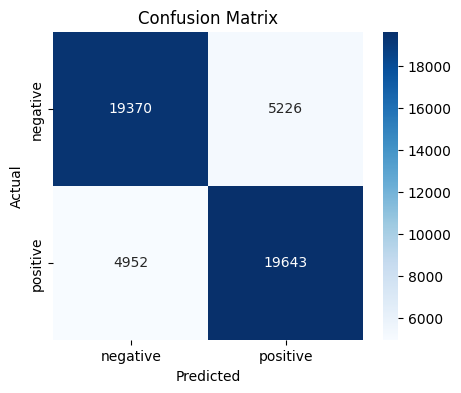

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = pipeline.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[id2label[0], id2label[4]]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[id2label[0], id2label[4]], yticklabels=[id2label[0], id2label[4]])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Sanity Check

In [10]:
# Quick inference test
sample_texts = [
    "I love this product! It works amazingly well.",
    "This is the worst experience ever.",
]

probs = pipeline.predict_proba(sample_texts)
preds = pipeline.predict(sample_texts)

for text, pred, prob in zip(sample_texts, preds, probs):
    label_name = id2label[pred]
    confidence = max(prob)
    print(f"Text: {text}\nPrediction: {label_name} (Confidence: {confidence:.2f})\n")


Text: I love this product! It works amazingly well.
Prediction: positive (Confidence: 0.98)

Text: This is the worst experience ever.
Prediction: negative (Confidence: 0.85)



# Saving the currently trained model with balanced dataset

In [11]:
import joblib

# Save the current pipeline
joblib.dump(pipeline, "sentiment_model_balanced.pkl")
print("Balanced subset model saved as sentiment_model_balanced.pkl ✅")


Balanced subset model saved as sentiment_model_balanced.pkl ✅


In [12]:
import json

# Save label mapping
with open("id2label_balanced.json", "w") as f:
    json.dump(id2label, f)
print("Label mapping saved as id2label_balanced.json ✅")


Label mapping saved as id2label_balanced.json ✅


In [13]:
# Load back the pipeline to verify
loaded_pipeline = joblib.load("sentiment_model_balanced.pkl")
print("Loaded model test prediction:", loaded_pipeline.predict(["I hate this!"]))


Loaded model test prediction: [0]


## Proceeding the Steps again to train Full dataset again (1.6M)

# Step 1 — Load full CSV


In [15]:
# Install if not already
!pip install -q kagglehub[pandas-datasets]

import kagglehub
import pandas as pd

# File path inside the dataset
file_path = "training.1600000.processed.noemoticon.csv"

# Load the dataset from Kaggle
df_full = kagglehub.load_dataset(
    kagglehub.KaggleDatasetAdapter.PANDAS,
    "abhi8923shriv/sentiment-analysis-dataset",
    file_path,
    pandas_kwargs={"header": None, "encoding": "latin-1"}  # to avoid encoding errors
)

# Assign column names
df_full.columns = ["polarity","tweet_id","date","query","user","text"]

# Quick check
print("Initial shape:", df_full.shape)
print("First 3 rows:\n", df_full.head(3))


/tmp/ipython-input-75041188.py:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_full = kagglehub.load_dataset(


Initial shape: (1048573, 6)
First 3 rows:
              polarity         tweet_id                          date  \
0  polarity of tweet   id of the tweet             date of the tweet   
1                   0       1467810672  Mon Apr 06 22:19:49 PDT 2009   
2                   0       1467810917  Mon Apr 06 22:19:53 PDT 2009   

      query           user                                               text  
0     query           user                                 text of the tweet   
1  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...  
2  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...  


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


# Step 2 — Clean dataset


In [18]:
# Convert polarity to string first
df_full["polarity"] = df_full["polarity"].astype(str)

# Keep only numeric polarity rows
df_full = df_full[df_full["polarity"].str.replace("\xa0","").str.isnumeric()]

# Now convert to int
df_full["polarity"] = df_full["polarity"].astype(int)

# Keep only relevant columns
df_full = df_full[["polarity","text"]]

# Drop duplicates and NaNs
df_full = df_full.drop_duplicates().dropna().reset_index(drop=True)

# Check cleaned dataset
print("Cleaned shape:", df_full.shape)
print("\nPolarity distribution:\n", df_full["polarity"].value_counts())
print("\nSample rows:\n", df_full.head(3))

/tmp/ipython-input-540126181.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["polarity"] = df_full["polarity"].astype(int)


Cleaned shape: (1036908, 2)

Polarity distribution:
 polarity
0    790181
4    246727
Name: count, dtype: int64

Sample rows:
    polarity                                               text
0         0  is upset that he can't update his Facebook by ...
1         0  @Kenichan I dived many times for the ball. Man...
2         0    my whole body feels itchy and like its on fire 


# Step 3 — Text Preprocessing


In [19]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"&\w+;", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_full["text_clean"] = df_full["text"].apply(clean_text)

# Quick check
print("Sample cleaned texts:\n", df_full[["text","text_clean","polarity"]].head(5))


Sample cleaned texts:
                                                 text  \
0  is upset that he can't update his Facebook by ...   
1  @Kenichan I dived many times for the ball. Man...   
2    my whole body feels itchy and like its on fire    
3  @nationwideclass no, it's not behaving at all....   
4                      @Kwesidei not the whole crew    

                                          text_clean  polarity  
0  is upset that he can't update his facebook by ...         0  
1  i dived many times for the ball. managed to sa...         0  
2     my whole body feels itchy and like its on fire         0  
3  no, it's not behaving at all. i'm mad. why am ...         0  
4                                 not the whole crew         0  


In [22]:
print(df_full.shape)

(1036908, 3)


# Step 4 — Train/Test Split


In [23]:
from sklearn.model_selection import train_test_split

X = df_full["text_clean"]
y = df_full["polarity"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Check shapes and label distribution
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

print("\nTraining label distribution:\n", y_train.value_counts())
print("\nTest label distribution:\n", y_test.value_counts())

Training set shape: (933217,)
Test set shape: (103691,)

Training label distribution:
 polarity
0    711163
4    222054
Name: count, dtype: int64

Test label distribution:
 polarity
0    79018
4    24673
Name: count, dtype: int64


# Step 5 — TF-IDF + Logistic Regression Pipeline


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline_full = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=150_000,
        ngram_range=(1,1),
        min_df=5,
        max_df=0.95,
        sublinear_tf=True,
        strip_accents='unicode'
    )),
    ('clf', LogisticRegression(
        solver='saga',
        max_iter=1000,
        class_weight='balanced',
        n_jobs=-1
    ))
])

print("Training on full dataset, please wait...")
pipeline_full.fit(X_train, y_train)
print("Full dataset training complete ✅")

Training on full dataset, please wait...
Full dataset training complete ✅


# Step 6 — Evaluation


Test Accuracy: 0.7949

Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.79      0.85     79018
    positive       0.55      0.80      0.65     24673

    accuracy                           0.79    103691
   macro avg       0.74      0.80      0.75    103691
weighted avg       0.84      0.79      0.81    103691



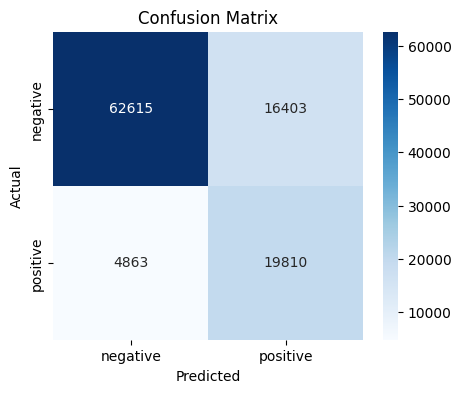

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = pipeline_full.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")

# Classification report
id2label = {0: 'negative', 4: 'positive'}
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[id2label[0], id2label[4]]))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[0], id2label[4]],
            yticklabels=[id2label[0], id2label[4]])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 7 — Save Model & Label Mapping for FastAPI

In [26]:
import joblib
import json

# Save full dataset pipeline
joblib.dump(pipeline_full, "sentiment_model_full.pkl")
print("Full dataset model saved as sentiment_model_full.pkl ✅")

# Save label mapping
id2label = {0: 'negative', 4: 'positive'}
with open("id2label_full.json", "w") as f:
    json.dump(id2label, f)
print("Label mapping saved as id2label_full.json ✅")


Full dataset model saved as sentiment_model_full.pkl ✅
Label mapping saved as id2label_full.json ✅


# Testing

In [27]:
sample_texts = [
    "I love this product! It works amazingly well.",
    "This is the worst experience ever."
]

probs = pipeline_full.predict_proba(sample_texts)
preds = pipeline_full.predict(sample_texts)

for text, pred, prob in zip(sample_texts, preds, probs):
    label_name = id2label[pred]
    confidence = max(prob)
    print(f"Text: {text}\nPrediction: {label_name} (Confidence: {confidence:.2f})\n")


Text: I love this product! It works amazingly well.
Prediction: positive (Confidence: 0.96)

Text: This is the worst experience ever.
Prediction: negative (Confidence: 0.89)



In [28]:
sample_texts = [
    "This is a good product.",
    "Seems perfect."
]

probs = pipeline_full.predict_proba(sample_texts)
preds = pipeline_full.predict(sample_texts)

for text, pred, prob in zip(sample_texts, preds, probs):
    label_name = id2label[pred]
    confidence = max(prob)
    print(f"Text: {text}\nPrediction: {label_name} (Confidence: {confidence:.2f})\n")


Text: This is a good product.
Prediction: positive (Confidence: 0.90)

Text: Seems perfect.
Prediction: positive (Confidence: 0.81)



In [29]:
sample_texts = [
    "Quality is not what I expected. disappointed.",
    "Thanks. best product ever."
]

probs = pipeline_full.predict_proba(sample_texts)
preds = pipeline_full.predict(sample_texts)

for text, pred, prob in zip(sample_texts, preds, probs):
    label_name = id2label[pred]
    confidence = max(prob)
    print(f"Text: {text}\nPrediction: {label_name} (Confidence: {confidence:.2f})\n")


Text: Quality is not what I expected. disappointed.
Prediction: negative (Confidence: 0.98)

Text: Thanks. best product ever.
Prediction: positive (Confidence: 0.98)



# Downloading Models

In [30]:
from google.colab import files

files.download("sentiment_model_full.pkl")
files.download("id2label_full.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>